In [1]:
%load_ext autoreload
%autoreload 2

## Example Notebook to use PyTFit5 with BLS CPU version and TransitFit5 transit modelling.

### VS Code Virtual Environment Setup
If you are using VS Code, it is recommended to create a virtual environment for this project. Here are the steps to create a virtual environment in VS Code:

- Open the Command Palette: Press Ctrl+Shift+P (or Cmd+Shift+P on Mac).
- Search: Type Python: Create Environment and select it.
- Choose Type: Select Venv.
- Select Interpreter: Choose the base Python version you have installed (e.g., Python 3.10, 3.11).
- Wait: VS Code will create a .venv folder in your project and automatically select it as your environment.

It is recommended to install this package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```

### Alternative Virtual Environment Setup
If you are not using VS Code, you can still create a virtual environment using the command line:

```bash
python -m venv bls_env         # Install create virtual environment that we will name 'bls_env'
source ./bls_env/bin/activate   # Active the new environment
pip install ipykernel           # Install iPython kernel
python -m ipykernel install --user --name=bls_env  # Add Kernel to Jupyter
(now make sure you have selected `bls_env` as your active Kernel for this notebook)
```

It is recommended to install bls_cuda package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```
### Package requirements:
- pytfit5
- numpy
- matplotlib
- tqdm
- numba
- scipy
- astroquery
- pandas

```bash
pip install numpy matplotlib tqdm numba scipy astroquery pandas
```

It is also recommended to install ipywidgets for Jupyter notebooks
```bash
pip install ipywidgets
```

In [2]:
import numpy as np
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5
import os

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

import importlib.util #To check if certain libraries are available 

In [3]:
import os
notebook_path = os.getcwd()+"/python/bls_cuda"
os.chdir(notebook_path)
print("Changed working directory to:", os.getcwd())

Changed working directory to: /home/rowe/python/bls_cuda


In [4]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
# gbls_inputs.lcdir    = "./"
# gbls_inputs.filename = "tlc"+str(tic)+"_5.d.dat"

gbls_inputs.lcdir = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/candidates/canrev_dataset1/"
gbls_inputs.filename = "tlc140511927/tlc140511927.p.dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Data should be normalized around 1 for BLS.  The example is centred around 0.  So we fix that here.
# phot.flux += 1.0  # Ensure flux is around 0
# phot.flux_f = phot.flux   # Make a copy of original flux

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

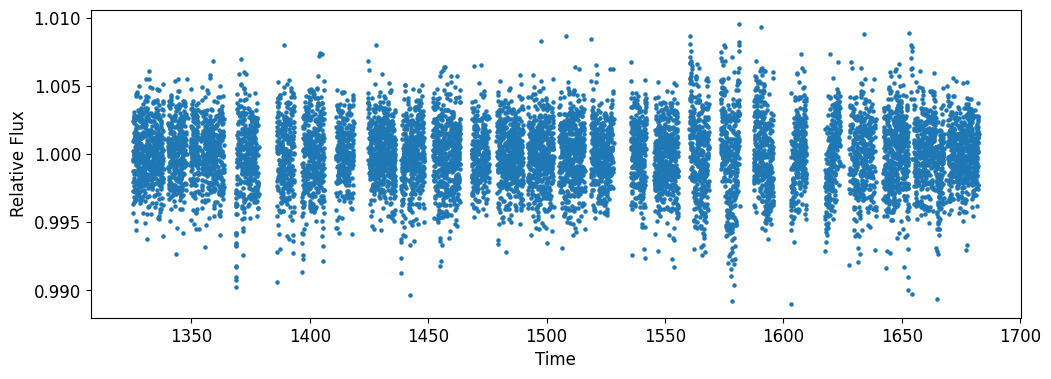

In [5]:
# Raw Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time,phot.flux, s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

In [14]:
import pprint
pprint.pprint(tpy5_inputs.__dict__)

{'boxbin': 5.0,
 'dataclip': 1,
 'detrended': 1,
 'dsigclip': 3.0,
 'e_feh': 0.3,
 'e_logg': 0.2,
 'e_mstar': 0.3,
 'e_rstar': 0.3,
 'e_teff': 500,
 'feh': 0.0,
 'fstd_cut': 5,
 'gapsize': 0.5,
 'logg': 4.5,
 'mstar': 1.0,
 'nfitp': 3,
 'nsampmax': 6,
 'photdir': '/path/to/photometry/',
 'photfile': 'filename.txt',
 'rjd': 2461345.5,
 'roi': 210.01,
 'rstar': 1.0,
 'teff': 5777}


Starting clipping: Window=2.0 days, Sigma=3.0
  Iteration 1: flagged 29 new outliers.
  Iteration 2: flagged 3 new outliers.
  Iteration 3: flagged 1 new outliers.
  Iteration 4: flagged 0 new outliers.


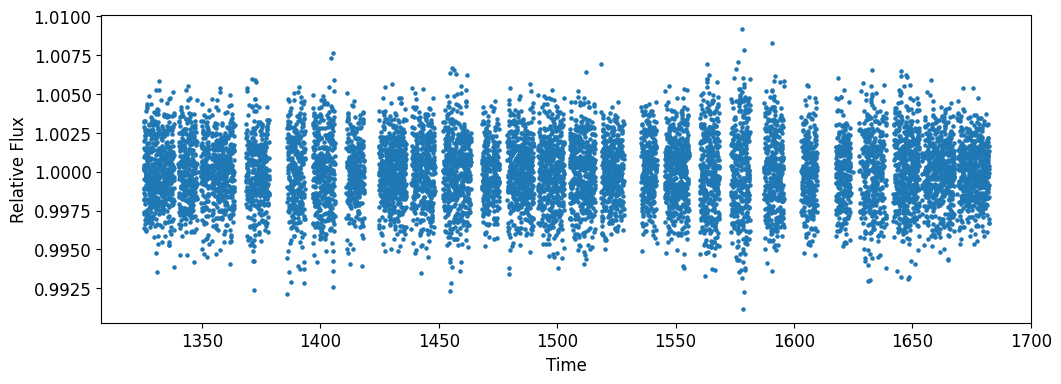

In [ ]:
## For testing detrending and outlier removal (can be removed)
phot.flux_f = np.copy(phot.flux)                # Make a copy of original flux
phot.icut = np.zeros(len(phot.time), dtype=int) # Initialize icut array to zero (good data)

# Get default parameters
tpy5_inputs = tpy5.tpy5_inputs_class()

# Run the detrending and outlier detection (if needed) 
tpy5_inputs.boxbin = 5.0 # set detrending length
tpy5_inputs.nfitp  = 3   # Set polynomial order
tpy5.run_polyfilter(phot, tpy5_inputs)  # flux_f will contain the filtered photometry
tpy5.run_cutoutliers(phot, tpy5_inputs) # data clipping, phot.icut will flag bad data
# tpy5.run_sigclip_global(phot, tpy5_inputs) # Simple sigma-clipping of data
tpy5.time_window_clip(phot, tpy5_inputs)  # Example of custom time-window clipping function

# Processed Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time[(phot.icut==0)],phot.flux_f[(phot.icut==0)], s=5)
# plt.scatter(phot.time[phot.icut==0],phot.flux_f[phot.icut==0], s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

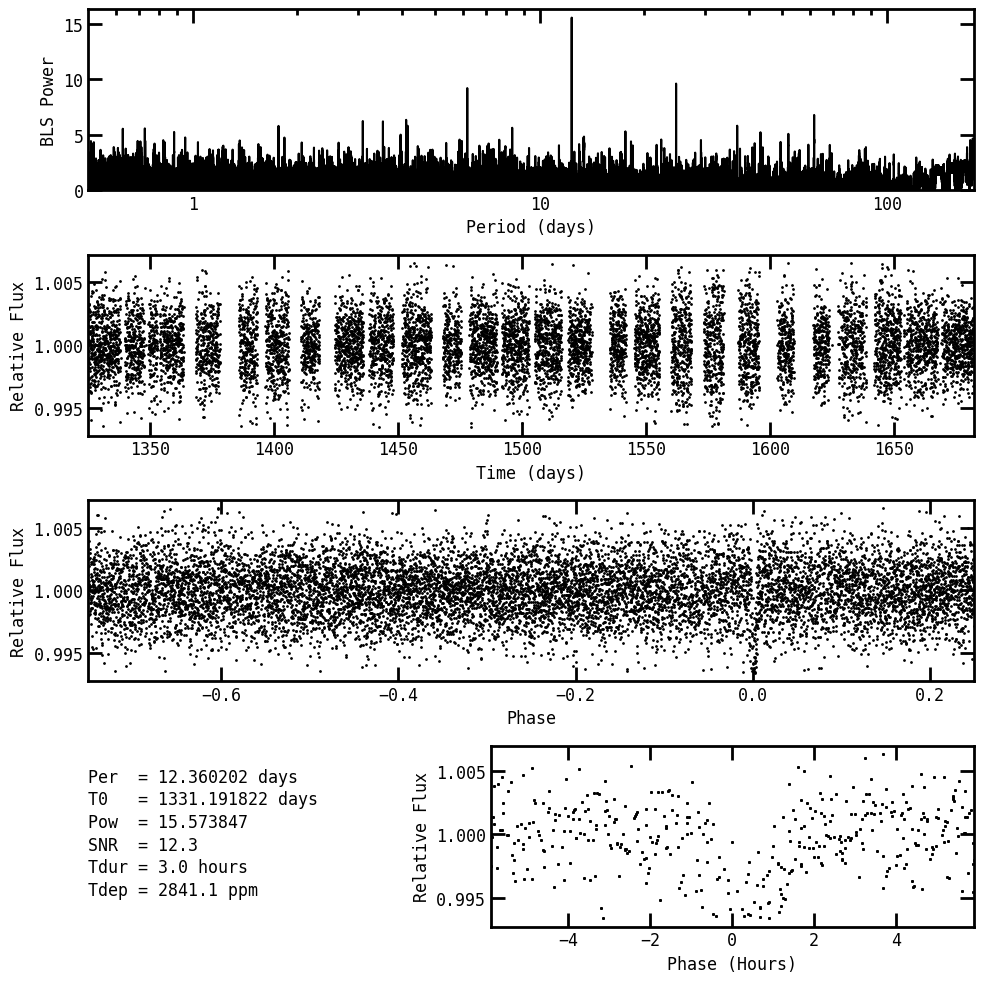

In [13]:
# Set up the BLS inputs and run
gbls_inputs          = gbls.gbls_inputs_class() # Initialize needed inputs
gbls_inputs.zerotime = 0.0
gbls_inputs.Rstar    = 1.0
gbls_inputs.Mstar    = 1.0
gbls_inputs.plots    = 1 # 1=X11, 2=both, 0=none
# Set frequency range
gbls_inputs.freq1    = 2/(np.max(phot.time) - np.min(phot.time)) # From 1/2 the time baseline -- i.e., 2 transits minimum
gbls_inputs.freq2    = -1 # default is 1/2 days
gbls_inputs.filename = "BLS_Test"  # Used for naming the file, extension replaced with PNG.

# Run BLS, applying data cuts
gbls_ans = gbls.bls(gbls_inputs, phot.time[(phot.icut==0)], \
                                 phot.flux_f[(phot.icut==0)])

## Python Transit modelling section

- needs preconditioning of data prior to modelling. (protect transits during detrending and clipping)
- move zerotime to routine to leave original phot.time intack
- use flux_f instead of flux for modelling -- leaves original photometry intack
- use icut and other flags to mark bad data 

In [6]:
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep
import pytfit5.transitfit as transitf
import pytfit5.transitplot as transitp

# Check for optional exotic limb darkening package.
if importlib.util.find_spec("exotic_ld"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

In [7]:
# Create an initial guess for all 18 parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

# Parameters that define the star/scene for the transit model
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
    ld_model = 'mps1'
    sld = StellarLimbDarkening(tpy5_inputs.feh, tpy5_inputs.teff, tpy5_inputs.logg, ld_model, ld_data_path)
    ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    sol.nl3 = ld[0]
    sol.nl4 = ld[1]
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [gbls_ans.epo + gbls_ans.bper]             # Center of transit time (days)
sol.per = [gbls_ans.bper*2]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]                      # sqrt(e)cos(w)
sol.esw = [0.0]                      # sqrt(e)sin(w)
sol.krv = [0.0]                      # RV amplitude (m/s)
sol.ted = [0.0]                      # thermal eclipse depth (ppm)
sol.ell = [0.0]                      # Ellipsodial variations (ppm)
sol.alb = [0.0]                      # Albedo amplitude (ppm)
sol.npl = 1                          # Number of planets

In [8]:
# Mark in-transit data.  Since BLS will likely underestimate the transit-duration, we will pad to be safe.
kep.mark_intransit_data(phot, sol, tdurcut = 1.0)  # tdurcut is the amount of +/- time to protect centred on the transit 
tpy5.run_polyfilter(phot, tpy5_inputs)         # Re-apply detrending to protect the transit event from distortion

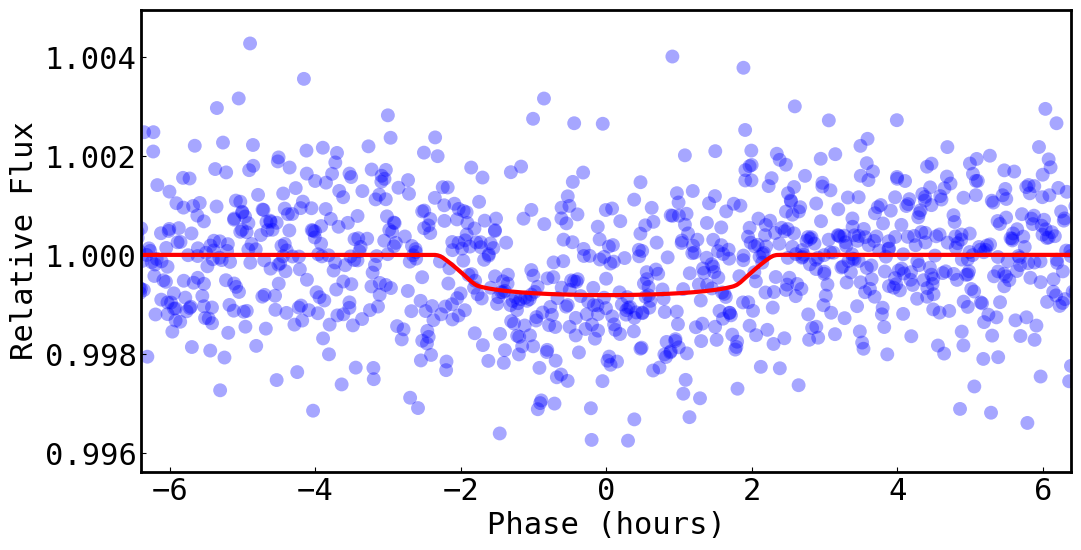

In [9]:
# Plot the initial model and data
pl_plot = 1 # Which planet to plot
transitp.plotTransit(phot, sol, pl_to_plot=pl_plot)

In [10]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [11]:
# See the fitted parameter (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.6463547 ± 17.3728205
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         7.245e-05 ± 7.199e-05
t0 (days):                      1.328e+03 ± 9.920e-03
Period (days):                  4.9661600 ± 0.0002462
Impact parameter:               0.5479418 ± 11.6533283
Rp/R*:                          0.0274593 ± 0.0445621
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


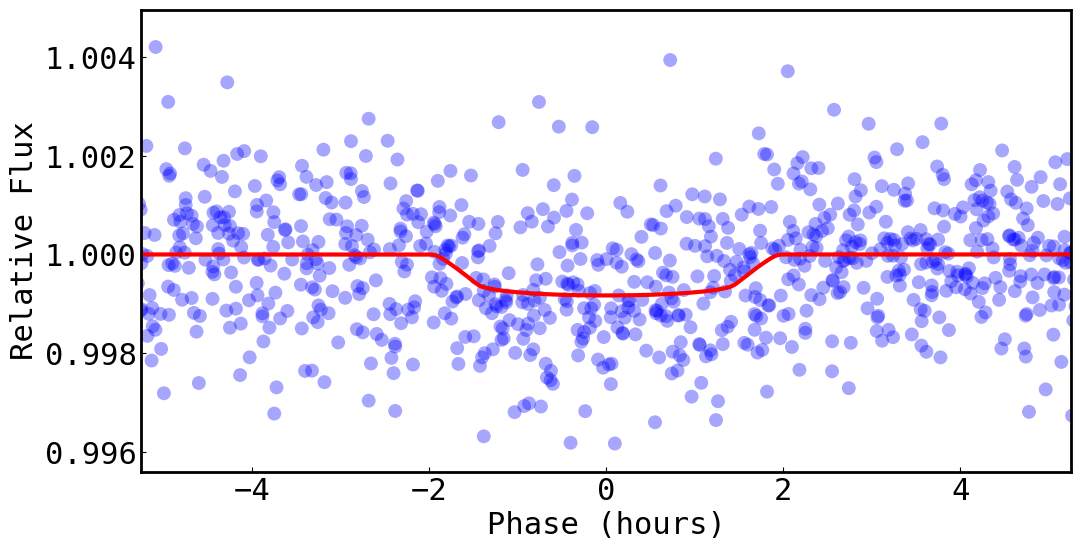

In [12]:
# Plot the optimized model and data
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

- add tqdm to MCMC chain generation to give user an indication of progress
- add flag to remove verbose output
- add figure generation that plots a selection of models from MCMC to show scatter. 

In [13]:
import pytfit5.transitmcmc as tmcmc

In [14]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [15]:
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [16]:
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.01367453 0.01484329 0.00019718 0.00043311]
Current Acceptance:  [0.01622419 0.60985915 0.5482866  0.54391371 0.00765697 0.04296296]
Current Acceptance:  [0.04891304 0.3379845  0.39375929 0.38950715 0.06119403 0.1146789 ]
Current Acceptance:  [0.19134078 0.2101227  0.23493976 0.1889881  0.15267176 0.25925926]
Current Acceptance:  [0.36377473 0.14329268 0.23493976 0.15395683 0.38599106 0.25925926]
Current Acceptance:  [0.41991342 0.13587786 0.23493976 0.16440422 0.38317757 0.25925926]
Current Acceptance:  [0.37223043 0.22489392 0.23493976 0.22157434 0.27662957 0.25925926]
Current Acceptance:  [0.29051988 0.22489392 0.23493976 0.22157434 0.27662957 0.25925926]
Current Acceptance:  [0.20865533 0.22489392 0.23493976 0.22157434 0.27662957 0.25925926]
Current Acceptance:  [0.2002924  0.22489392 0.23493976 0.22157434 0.27662957 0.25925926]
Current Acceptance:  [0.20950966 0.22489392 0.23493976 0.22157434 0.27662957 0.25925926]
Current Acceptance:  [0.24159021 0.22489392 0.23493976 

In [17]:
# Get statistics about the posterior from the Markov-Chain and print the results
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

# you can get any individual value from the sol_mcmc class, for example the mean stellar density : rho and drho 

ρ* (g/cm³):                     0.4342016 ± 0.7679794
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         6.789e-05 ± 7.995e-05
t0 (days):                      1.328e+03 ± 1.987e-02
Period (days):                  4.9663098 ± 0.0004525
Impact parameter:               0.6267667 ± 0.3649895
Rp/R*:                          0.0277791 ± 0.0186779
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


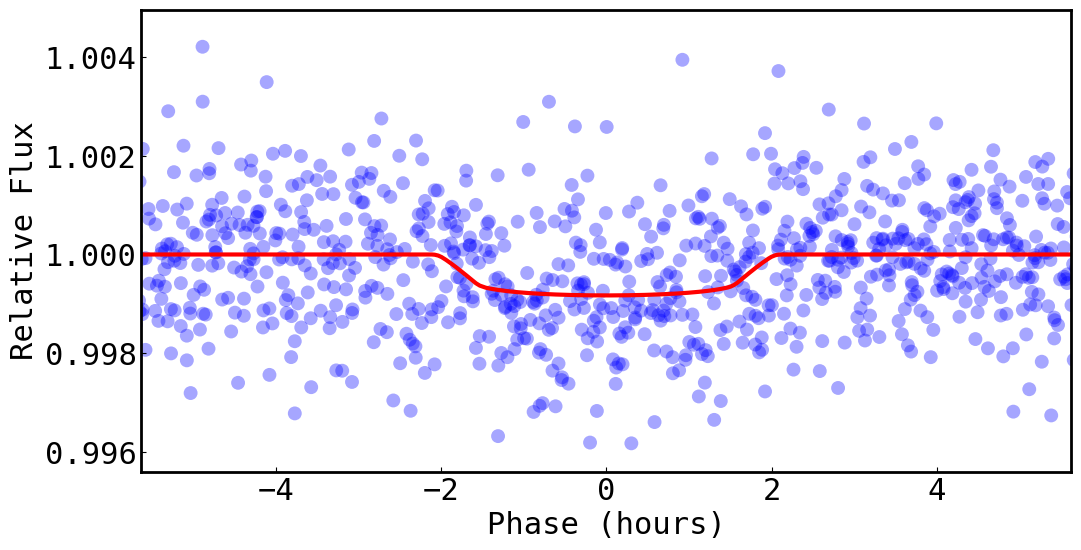

In [18]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

In [19]:
import pytfit5.mcmcroutines as mcmc

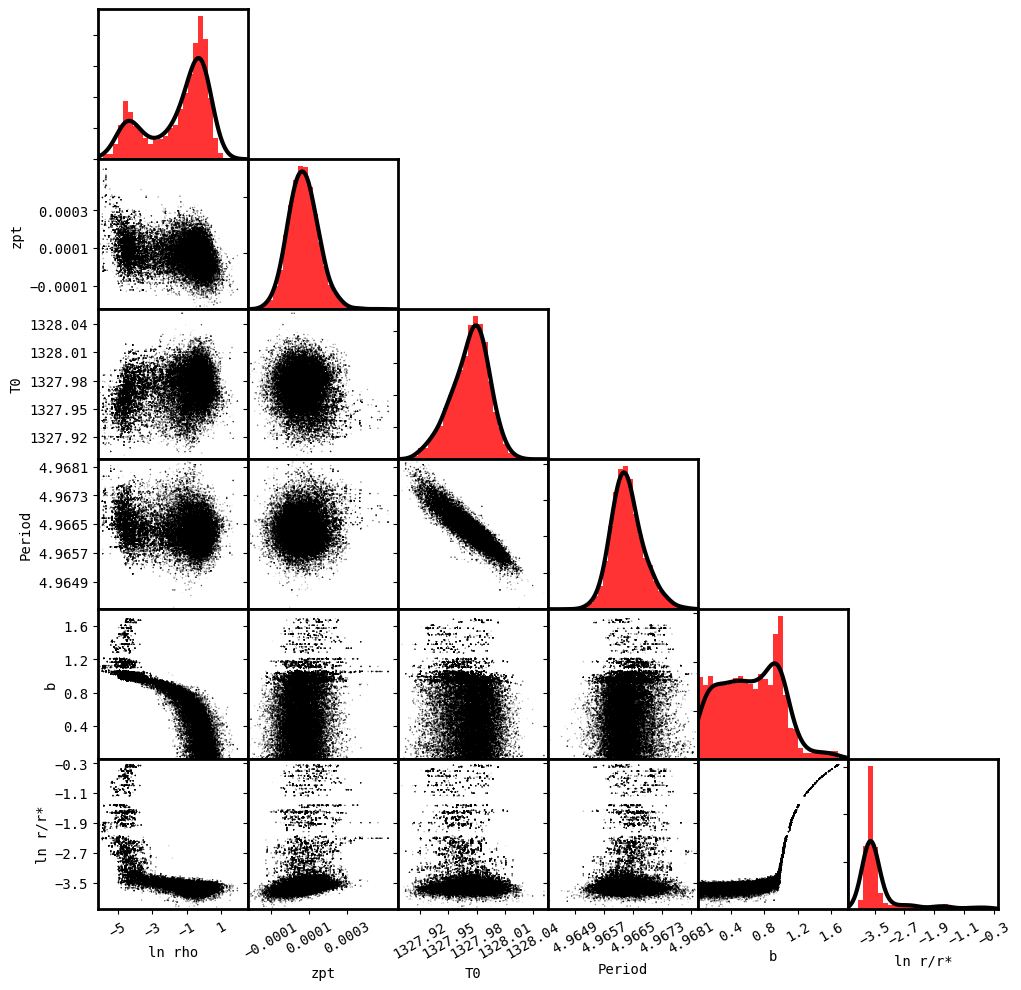

In [20]:
label = ["ln rho", "zpt", "T0", "Period", "b", "ln r/r*"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)